<b>Autor: </b>Matthias Titze, s0563413   
# <font color='grey'> NHANES 4 </font><font color='#0099ff'>- Supervised Machine Learning</font>   
<b>Nationial Health and Nutrition Survey<b>

### Bibliotheken Importieren

In [136]:
# Standard library
import os
import math
import random
import itertools
# Dataframe handling
import numpy as np
import pandas as pd
# Machine leraning libraries
from sklearn import datasets 
from sklearn.metrics import classification_report 
from sklearn.metrics import confusion_matrix 
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB 
# Matplotlib
import matplotlib.pyplot as plt
from matplotlib import cm
import matplotlib.patches as mp
%matplotlib inline
# Seaborn plots
import seaborn as sns
# Hide warnings
import warnings
warnings.filterwarnings('ignore')

### Plot-Funktionen

In [120]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

### Daten Importieren

In [17]:
path_input = os.path.join('00_data_input')
path_output = os.path.join('03_data_output')
path_categ = os.path.join(path_output, 'nhanes_categ.csv')

In [18]:
df_categ = pd.read_csv(path_categ)
df_categ.head()

,id,CODE_status,CM_height,KG_weight,KG_M2_bmi,CODE_bmi_category_youth,BINARY_gender,YEARS_age,CODE_race,CODE_race_extended,...,CAT_bmi,LAB_bmi,STR_bmi,CAT1_race,CAT2_race,CODE2_race,CAT_houshold_education,LAB_houshold_education,CAT_income_houshold,LAB_income_houshold
0,41475,3,154.7,138.9,58.04,NaN,2,62,5,NaN,...,4.0,40+,obese3,otherOld,other,1,4,4_AA-Degree,6.0,025-035K
1,41476,1,120.4,22.0,15.18,NaN,2,6,5,NaN,...,-1.0,10-18,underweigt,otherOld,other,1,5,5_College+,12.0,100+K
2,41477,1,167.1,83.9,30.05,NaN,1,71,3,NaN,...,2.0,30-35,obese1,white,white,1,3,3_Highschool,5.0,020-025K
3,41478,1,NaN,11.5,NaN,NaN,2,1,3,NaN,...,NaN,unknown,unknown,white,white,1,2,2_<12th-Grade,3.0,010-015K
4,41479,1,154.4,65.7,27.56,NaN,1,52,1,NaN,...,1.0,25-30,overweight,mexican,mexican,1,1,1_<9th-Grade,8.0,045-055K


# <font color='grey'> Vorhersagemodell - </font><font color='#0099ff'>Supervised Machine Learning</font>   
Im Folgenden soll versucht werden, ein Vorhersagemodell (Klassifizierung) für Untersuchte Eigenschaft der BMI-Klasse zu erstellen. Dazu verwenden wir Supervised Machine Learning Algorithmen, d.h. die vorhandenen Daten werden in Trainingsdaten und Testdaten unterteilt. Mit den ersteren Trainieren wir den Prognose-Algorithmus. Anschließend lassen wir diesen über die Testdaten eine Vorhersagetreffen treffen und vergleichen das Resultat mit den für die Testdaten vorliegenden, realen Merkmalsausprägungen. So wird eine Einschätzung bezüglich der Qualität des Modells möglich.   
<b>Limitationen: </b> Da die bisherigen Untersuchungen gezeigt haben, dass es für die Tendenz zu Übergewicht und Fettleibigkeit keine entscheidenden sozioökonomischen Faktoren gibt, muss vermutet werden, dass auch eine Machine-Learning-Algorithmus keine klaren Aussagen treffen kann. Dies ist insbesondere für den Ansatz der Klassifizierung des Körpergewichts, einer Eigenschaft, die eher normal verteilt ist, anzunehmen: Auch wenn es Faktoren gäbe, die eine Tendenz zur Adipositas leicht begünstigen würden, wäre die so gesteigerte Wahrscheinlichkeit immer noch geringer als der Druck hin zum Erwartungswert der Normalverteilung. Klassifizierung als Vorhersagemodell ist somit eher nicht der treffende Ansatz. Günstiger wäre ein Modell, welches eine Aussage darüber treffen würde, in welchem Maß die Wahrscheinlichkeit durch entsprechende Einflussfaktoren beinflusst wird. Trotz dieser grundsätzlichen Problematik soll, die Klassifizierung mit Naive Bayes getestet werden. Treffen wir dort auf überraschende Ergebnisse, so findet sich im Umkehrschluss in den Daten doch eine Kombination von Eigenschaften, die kritisch für die Ausbildung von Adipositas ist.    

<b>Vorherzusagen (y): </b>BMI-Klasse {Untergewicht, Normal, Übergewicht, Adipositas 1-3}   
<b>Genutzte Merkmale (xi): </b> {Geschlecht, Ethnie, Anzahl Mitglieder im Haushalt, Haushaltseinkommen, Bildung, Alter}

### Klassifizierung mit Naive Bayes (Gauss)
Der Naive Bayes Klassifizierer basiert auf Bayes Theorem. Er wird als "naive" bezeichnet, da er die Unabhängigkeit aller einbezogenen  Merkmalspaare im Datensatz voraussetzt. V = (x1, x2, …, xn) sei der Vektor der Merkmale und y die Eigenschaft, die durch den Vektor voraus gesagt werden soll. Dann gilt:  

$$P(y|x_{1},...,x_{n}) = \frac{P(y)P(x_{1},...x_{n}|y)}{P(x_{1},...,x_{n})}$$   
und wenn x1, x2,...,xn weiterhin als stochastisch unabhängig angenommen werden:  

$$P(y|x_{1},...,x_{n}) = \frac{P(y)\prod_{i=1}^{n}P(x_{i}|y)}{P(x_{1},...,x_{n})}$$   

Diese Formel reduziert sich für die Klassifizierung weiter zu:   
$$P(y|x_{1},...,x_{n}) = P(y)\prod_{i=1}^{n}P(x_{i}|y)$$

,da die errechneten Wahrscheinlichkeiten nur auf das Maximum ausgewertet werden. P(xi) ist eine Konstante, die in allen so verglichenen Werteberechnungen auftritt und somit ignoriert werden kann. Im Falle des hier verwendeten Gauss-Naive-Klassifizierers aus der Python ScikitLearn Blibliothek, wird eine Normalverteilung jedes Merkmals angenommen. Dann ergibt sich die Wahrscheinlich dafür zu:   

$$P(x_{i}|y) = \frac{1}{\sqrt{2\pi\sigma_{y}^{2}}}\exp(-\frac{(x_{i}-\mu_{
y})^2}{2\sigma_{y}^{2}})$$   

<b>Potenzielle Fehlerquellen: </b> Schon vorab muss der gewählte Klassifikator kritisch betrachtet werden. Die Merkmale, Einkommen und Ausbildung, sind zum Beispiel keinesfalls unabhängig. Dies wurde in der Datenexploration nachgewiesen. Des Weiteren ist eigentlich nicht davon Auszugehen, das die zur Vorhersage genutzten Eigenschaften normal verteilt sind.

### Daten Selektieren    
Aus dem NHANES-Datensatz werden die oben genannten Merkmale als Grundlage für die Klassifizierung extrahiert. Vorauszusagen ist die BMI-Gruppe. Alle genutzten Daten liegen als kategorisierte Eigenschaften vor, die hier in Form von Integer-Zahlen codiert wurden. Auf fehlende Daten wurde der Einfachheit halber mit Ausschluss reagiert. Die Anzahl der Zeilen schrumpft so auf 40.686, was für den angestrebten Rahmen genügen soll.

In [60]:
# Select relevant columns from the categorized dataframe.
df_bayes = df_categ[['id',
                     'BINARY_gender',
                     'CODE2_race',
                     'CNT_houshold_members',
                     'CAT_income_houshold',
                     'CAT_houshold_education',
                     'CODE1_age',
                     'CAT_bmi']].copy()
# Drop nan values.
df_bayes = df_bayes.dropna()
# Unknown education was set to 0 value - drop these.
df_bayes = df_bayes[df_bayes['CAT_houshold_education'] != 0]
# Unknown age was set to 0 value - drop these.
df_bayes = df_bayes[df_bayes['CODE1_age'] != 0]
# Convert floats to integer code (possible as nan was removed).
df_bayes['CAT_bmi'] = df_bayes['CAT_bmi'].astype(int)
df_bayes['CAT_income_houshold'] = df_bayes['CAT_income_houshold'].astype(int)
# Rename to improve readablity.
df_bayes.rename(columns={'BINARY_gender':'gender',
                         'CODE2_race':'race',
                         'CNT_houshold_members':'members',
                         'CAT_income_houshold':'income',
                         'CAT_houshold_education':'education',
                         'CODE1_age':'age',
                         'CAT_bmi':'bmi'}, inplace=True)

df_bayes = df_bayes.reset_index()
df_bayes = df_bayes.drop('index', axis=1)
df_bayes.head()

,id,gender,race,members,income,education,age,bmi
0,41475,2,1,2,6,4,13,4
1,41476,2,1,6,12,5,2,-1
2,41477,1,1,2,5,3,15,2
3,41479,1,1,5,8,1,11,1
4,41480,1,1,7,7,2,2,-1


### Klassifikator Trainieren
Der so extrahierte Datensatz wir anschließend zufällig in 75% Trainings- und 25% Testdaten unterteilt. Mit den ersteren trainieren wir den den Naive-Bayes-Gauss Klassifikator aus der Python Bibliothek. Anschließend erfolgt die Vorhersage auf den Trainingsdaten.

In [61]:
df_bayes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40686 entries, 0 to 40685
Data columns (total 8 columns):
id           40686 non-null int64
gender       40686 non-null int64
race         40686 non-null int64
members      40686 non-null int64
income       40686 non-null int64
education    40686 non-null int64
age          40686 non-null int64
bmi          40686 non-null int64
dtypes: int64(8)
memory usage: 2.5 MB


In [68]:
# x -> features, y -> label to predict
x = df_bayes.drop(['bmi','id'], axis=1)
y = df_bayes['bmi']

In [69]:
x.head()

,gender,race,members,income,education,age
0,2,1,2,6,4,13
1,2,1,6,12,5,2
2,1,1,2,5,3,15
3,1,1,5,8,1,11
4,1,1,7,7,2,2


In [70]:
y[:5]

0    4
1   -1
2    2
3    1
4   -1
Name: bmi, dtype: int64

In [83]:
# Dividing x, y into train and test data.
x_train, x_test, y_train, y_test = train_test_split(x, y, random_state = 120) 
# Training a Naive Bayes classifier.
gnb = GaussianNB().fit(x_train, y_train) 
gnb_predictions = gnb.predict(x_test) 

### Bewertung des Modells   
Die erhaltenen Vorhersagen können in Beziehung zu den tatsächlich vorliegenden Daten für den BMI abgeglichen werden.  
<b>Wertebereiche: </b> Schon bei der Überprüfung der Wertebereiche tritt Bedenkliches zu Tage: Während die tatsächlichen Werte, alle BMI-Klasssen umfassen, liegen die vorher gesagten Ausprägungen nur in den Kategorien -1 (Untergewicht) bis 1 (leichteres Übergewicht). Der Klassifikator hat also versagt, Personen mit Adipositas 1-3 zu erkennen. Davon war jedoch von Beginn an auszugehen, da die betrachteten Faktoren nur einen leichten Einfluss auf die Tendenz zur Fettleibigkeit haben. Der Naive Bayes wählt bekanntlich, die wahrscheinlichste Klasse aus. Auch wenn also Adipositas durch einige Merkmale etwas wahrscheinlicher würde, so bleibt der Erwartungswert der Normalverteilung eben doch dominant.  
<b>Genauigkeit: </b> Die Genauigkeit des Klassifikators wird mit 40,68 Prozent beziffert. Dies ist ein schwacher Wert.

In [85]:
print('Maximum BMI in test data:', max(y_test))
print('Minimum BMI in test data:', min(y_test))
print('Maximum BMI predeicted:', max(gnb_predictions))
print('Minimum BMI predeicted:', min(gnb_predictions))

Maximum BMI in test data: 4
Minimum BMI in test data: -1
Maximum BMI predeicted: 1
Minimum BMI predeicted: -1


In [86]:
# Accuracy on x_test.
accuracy = gnb.score(x_test, y_test) 
print('Naive Bayes Classifier accuracy: ', accuracy)
# Create a confusion matrix .
cm = confusion_matrix(y_test, gnb_predictions) 

Naive Bazyes Classifier accuracy:  0.4069012976799056


In [87]:
cm

array([[1930,   88,   45,    0,    0,    0],
       [1235,  927,  914,    0,    0,    0],
       [ 359,  795, 1282,    0,    0,    0],
       [ 152,  478,  820,    0,    0,    0],
       [  70,  260,  317,    0,    0,    0],
       [  41,  215,  244,    0,    0,    0]])

#### Modifikation der BMI-Klassen     
Da die drei oberen BMI-Klassen (Adipositas 1-3) im Einzelnen bei allen Testpersonen deutlich weniger häufig auftreten sind sie auch unwahrscheinlicher. Wir erhoffen uns demnach eine leicht verbesserte Aussage, wenn wir diese Klassen in eine allgemeinere Gruppe, "Adipositas", verschmelzen. Der Trainings- und Vorhersageprozess muss dann wiederholt werden.

In [133]:
# Merge all the obese bmi-classes into one category, so that the classifier has a better chance to go there.
for row in df_bayes.index:
    df_bayes.at[row,'bmi_redux'] = df_bayes.at[row,'bmi']
    if (df_bayes.at[row,'bmi'] == 4):
        df_bayes.at[row,'bmi_redux'] = 2
    elif (df_bayes.at[row,'bmi'] == 3):
        df_bayes.at[row,'bmi_redux'] = 2
        
df_bayes['bmi_redux'] = df_bayes['bmi_redux'].astype(int)
df_bayes.head()

,id,gender,race,members,income,education,age,bmi,bmi_redux
0,41475,2,1,2,6,4,13,4,2
1,41476,2,1,6,12,5,2,-1,-1
2,41477,1,1,2,5,3,15,2,2
3,41479,1,1,5,8,1,11,1,1
4,41480,1,1,7,7,2,2,-1,-1


In [139]:
# x -> features, y -> label to predict
x2 = df_bayes.drop(['bmi','bmi_redux','id'], axis=1)
y2 = df_bayes['bmi_redux']
# Dividing x, y into train and test data.
x2_train, x2_test, y2_train, y2_test = train_test_split(x2, y2, random_state=10) 
# Training a Naive Bayes classifier.
gnb2 = GaussianNB().fit(x2_train, y2_train) 
gnb2_predictions = gnb.predict(x2_test) 

#### Bewertung des angepassten Modells   
Auch nach Neueinteilung der BMI-Klassen bleibt das Problem erhalten: Es besteht keine Möglichkeit, krankhafte Fettleibigkeit vorher zu sagen. Dies ist vielleicht auch beruhigend, da somit klar wird, dass sozioökonomische Faktoren eben nicht allein über das Körpergewicht entscheiden, sondern maximal eine Tendenz fördern könnten. Der Naive Bayes Klasifikator ist jedoch nicht dafür geignet eine deratige Verschiebung abzubilden. Die Genauigkeit ist mit 41,17 Prozent nur leicht verbessert und könnte schon damit erklärt werden, dass wir die Personen richtig vorher sagen, die ohnehin im Mittelfeld liegen.    
<b>Konfusionsmatrix:</b> Um die Trefferquote genauer zu beleuchten, hilft eine Matrix, welche die realen und die vorher gesagten Merkmalsausprägungen gegenüber stellt. Wir können also erkennen, wie viele Treffer in jeder Klasse gefunden wurden und wohin sich die Alpha-Fehler bewegt haben. In normalisierter Form ist der prozentuale Trefferanteil erfasst. In unserem Modell wird somit eine erstaunlich präzise Aussage über die Testpersonen mit Untergewicht getroffen. Von 2114 Teilnehmern werden 1960 richtig eingeschätzt. Das ist eine Trefferquote von 93 Prozent. Dieser gute Wert verlangt eigentlich eine Folgeuntersuchung, die ergründet, ob es markante Einzelindikatoren wie Alter (Jugendliche), Ethnie (Asiaten) und Einkommen (extreme Armut) gibt. Dies lag aber nicht im Fokus dieser Arbeit. Die Vorhersage der Normalgewichtigen ist sehr ungenau - nur 32 Prozent werden richtig erfasst. Viel zu viele Personen wurden ins Untergewicht verschoben (wo dann ein großer Beta-Fehler vorliegt). Die Vorhersage der leicht Übergewichtigen ist mit 52 Prozent etwas genauer. Immerhin wird dort der Schwerpunkt richtig gesetzt. Das Hauptproblem liegt bei der Kategorie "Adipös": Die Vorhersage dazu hat sich komplett in den über- und normalgewichtigen Teil verschoben. Die Trefferquote liegt so bei 0.

In [140]:
# Accuracy on x_test.
accuracy2 = gnb.score(x2_test, y2_test) 
print('Naive Bayes Classifier accuracy: ', accuracy2)
# Create a confusion matrix .
cm2 = confusion_matrix(y2_test, gnb2_predictions) 

Naive Bayes Classifier accuracy:  0.41171844278411324


Confusion matrix, without normalization
Normalized confusion matrix


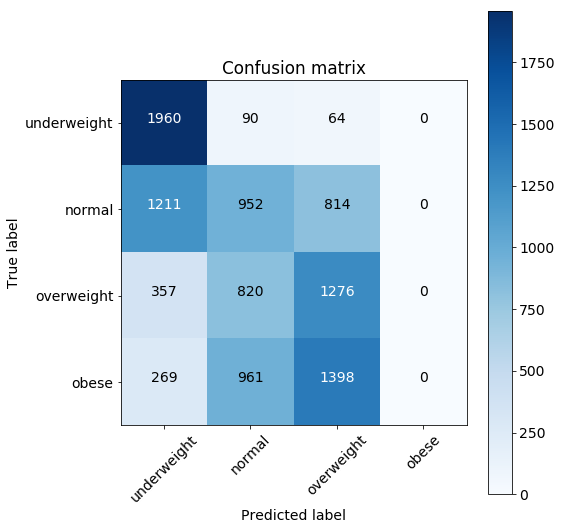

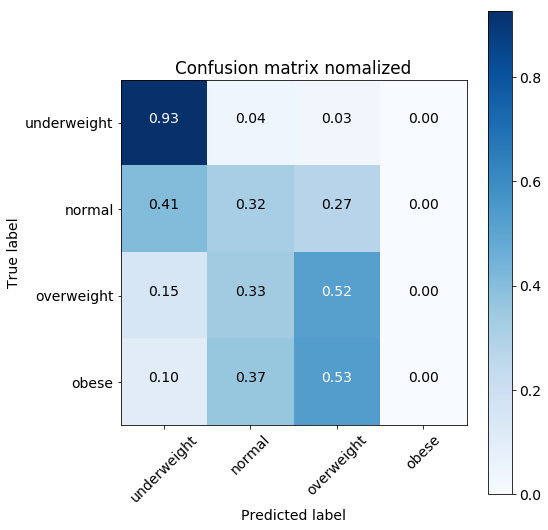

In [132]:
# Relabel the coded bmi-categories.
class_names = ['underweight','normal','overweight','obese']
# Plot normalized confusion matrix.
np.set_printoptions(precision=2)
plt.rc('font', size=14)
plt.figure(figsize=(8, 8))
plot_confusion_matrix(cm2, classes=class_names, title='Confusion matrix', normalize=False)
plt.figure(figsize=(8, 8))
plot_confusion_matrix(cm2, classes=class_names, title='Confusion matrix nomalized', normalize=True)
plt.show()

### Fazit
Das Klassifikator-Modell ist sehr schwach. Bei guter Aussagekraft erwarten wir die Konfusionsmatrix eine deutlich ausgeprägte Hauptdiagonale. Diese ist jedoch zumindest schwach zu erkennen - die Verteilung der Schätzwerte ist keinesfalls zufällig. Dass bedeutet vielleicht, dass die angedachten Zusammenhänge nicht ganz abzustreiten sind, durch den Naive-Bayes aber auch schlecht nachgewiesen werden können. Bei der Anwendung von Klassifizierern bleibt as Problem bestehen, dass leicht gesteigerte Wahrscheinlichkeiten keinen Ausdruck finden. Gerade für diese Untersuchung wäre eine Berechnung solcher Werte interessant. Die Methodik für eine derartige Annäherung an das Thema lag zum Zeitpunkt der Arbeit nicht in Reichweite.

In [141]:
print(classification_report(y2_test, gnb2_predictions))

             precision    recall  f1-score   support

         -1       0.52      0.93      0.66      2114
          0       0.34      0.32      0.33      2977
          1       0.36      0.52      0.42      2453
          2       0.00      0.00      0.00      2628

avg / total       0.29      0.41      0.34     10172

